In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Метрики регрессии

Создадим синтетические данные с выбросами

In [2]:
gen = np.random.RandomState(42)
data = 1 + np.concatenate((
    np.abs(gen.normal(loc=0., scale=100, size=10000)), # основные данные
    np.abs(30000 * gen.standard_cauchy(size=10)) # небольшая часть выбросов
))

Напишите реализацию метрик регрессии (попробуйте не использовать sklearn)

In [3]:
def mae(answers, predictions):
    # TODO допишите реализацию
    return np.mean(np.abs(answers - predictions))

def rmse(answers, predictions):
    # TODO допишите реализацию
    return np.sqrt(np.mean((answers - predictions) ** 2))

def mape(answers, predictions):
    # TODO допишите реализацию
    return np.mean(np.abs(answers - predictions) / answers)

def smape(answers, predictions):
    # TODO допишите реализацию
    return 2. * np.mean(np.abs(answers - predictions) / (np.abs(answers) + np.abs(predictions)))

Визуализируем зависимость качества от константы, которой мы будем предсказывать целевые переменные

In [4]:
def plot(x_coords, y_coords):
    plt.figure(figsize=(10, 6))
    plt.ylim(np.min(y_coords), np.max(y_coords))
    plt.xlim(np.min(x_coords), np.max(x_coords))
    plt.plot(x_coords, y_coords)
    plt.grid()
    plt.show()

In [5]:
x_coords = list(range(0, 250, 5)) # диапазон значений

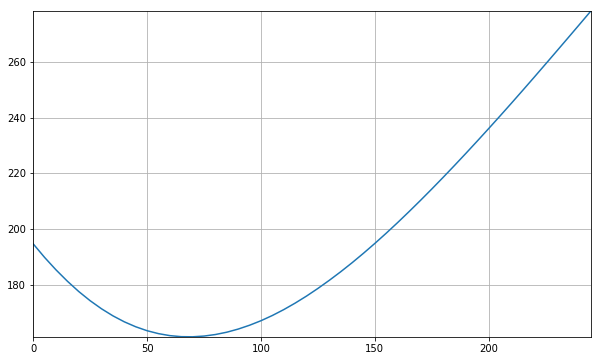

In [6]:
plot(x_coords, [mae(data, x) for x in x_coords])

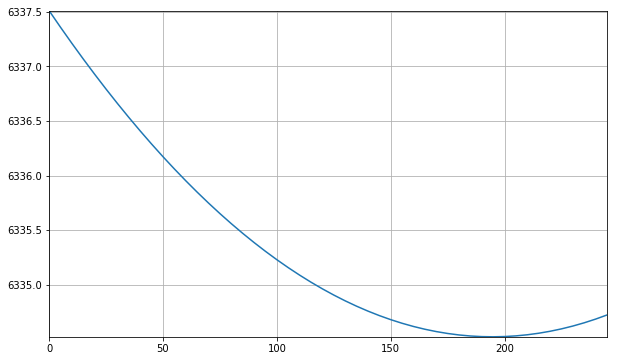

In [7]:
plot(x_coords, [rmse(data, x) for x in x_coords])

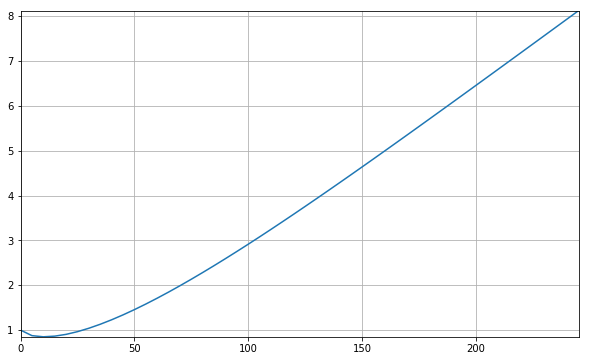

In [8]:
plot(x_coords, [mape(data, x) for x in x_coords])

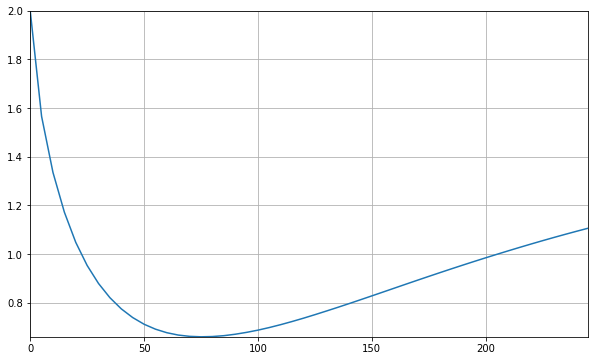

In [9]:
plot(x_coords, [smape(data, x) for x in x_coords])

Объясните наблюдаемые эффекты для каждого графика:
* Почему кривая имеет такую форму?
* Где её точный оптимум (возможно, придётся написать дополительный код)?
* Какие выводы можно сделать с точки зрения использования метрики для оценки алгоритма?

In [10]:
# mae optimal
print(np.median(data))

# mse optimal
print(data.mean())

# mape optimal
# нам нужно найти переход от отрицательной производной к положительной
sorted_data = np.sort(data)
coeffs = 1. / sorted_data
left_sums = np.cumsum(coeffs)[:-1]
right_sums = np.cumsum(coeffs[::-1])[::-1][1:]
diffs = left_sums - right_sums
num = np.argmax(diffs[diffs < 0]) + 1
print(sorted_data[num])

# mape optimal, используя scipy (неточный)
from scipy.optimize import minimize

def fun(x):
    return mape(data, x)

print(minimize(fun, 1).x[0])

# smape optimal (неточный)
from scipy.optimize import minimize

def fun(x):
    return smape(data, x)

print(minimize(fun, 75).x[0])

68.24395901664192
194.6330976382524
10.175248444837287
10.174474484984554
75.58866738776679


## Метрики классификации при дисбалансе классов

In [11]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

Воспользуемся sklearn реализацией метрик

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

Возьмём стандартный датасет для классификации из sklearn

In [13]:
X_data, y_data = load_breast_cancer(return_X_y=True)

Разделим на train и test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.5, random_state=42)

Импортируем алгоритм для обучения

In [15]:
from xgboost import XGBClassifier

Строим модель

In [16]:
model = XGBClassifier(n_estimators=1000, random_state=42).fit(X_train, y_train)

In [17]:
accuracy_scores = []
recall_scores = []
precision_scores = []
f1_scores = []
roc_auc_scores = []

points = list(range(1, 101))

for k in points:
    # TODO постройте список индексов, такой, 
    # чтобы каждый индекс 0 на тесте был один раз, а каждый индекс 1 на тесте был k раз
    indices = list(np.where(y_test == 0)[0]) + list(np.where(y_test == 1)[0]) * k
    
    X = X_test[indices, :]
    y = y_test[indices]
    
    y_pred = model.predict(X)
    accuracy_scores.append(accuracy_score(y, y_pred))
    recall_scores.append(recall_score(y, y_pred))
    precision_scores.append(precision_score(y, y_pred))
    f1_scores.append(f1_score(y, y_pred))
    roc_auc_scores.append(roc_auc_score(y, y_pred))
        

Отобразим кривые в зависимости от $k$

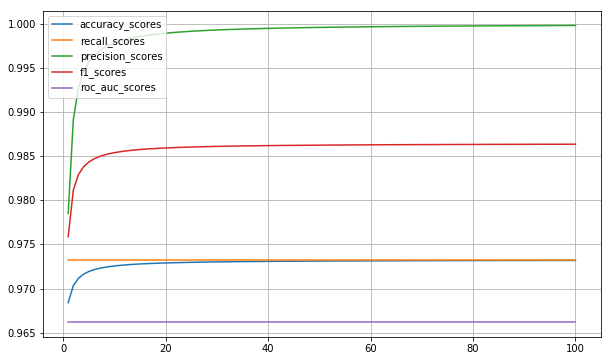

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(points, accuracy_scores)
plt.plot(points, recall_scores)
plt.plot(points, precision_scores)
plt.plot(points, f1_scores)
plt.plot(points, roc_auc_scores)
plt.grid()
plt.legend([
    'accuracy_scores',
    'recall_scores',
    'precision_scores',
    'f1_scores',
    'roc_auc_scores'
], loc='best')
plt.show()

* Почему кривые такие? Почему некоторые не меняются, а некоторые меняются
* Почему у кривых такие асимптотические значения? Почему у некоторых они совпадают?
* Какие выводы можно сделать с точки зрения использования метрики для оценки алгоритма?

### Оптимальные гиперпараметры при обучении

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [20]:
def estimate_algo(algo):
    print(algo.best_params_)
    print('Train:')
    y_pred = algo.predict(X_train)
    print('\taccuracy_score', accuracy_score(y_train, y_pred))
    print('\trecall_score', recall_score(y_train, y_pred))
    print('\tprecision_score', precision_score(y_train, y_pred))
    print('\tf1_score', f1_score(y_train, y_pred))
    print('\troc_auc_score', roc_auc_score(y_train, y_pred))
    print('Test:')
    y_pred = algo.predict(X_test)
    print('\taccuracy_score', accuracy_score(y_test, y_pred))
    print('\trecall_score', recall_score(y_test, y_pred))
    print('\tprecision_score', precision_score(y_test, y_pred))
    print('\tf1_score', f1_score(y_test, y_pred))
    print('\troc_auc_score', roc_auc_score(y_test, y_pred))
    

Ниже будут перебираться гиперпараметры и находиться оптимальный алгоритм. Почему получаются именно такие гиперпараметры?

In [21]:
print('accuracy optimal')
estimate_algo(GridSearchCV(
    XGBClassifier(random_state=42), 
    param_grid=dict(
        n_estimators=[5, 10, 20, 25],
        max_depth=[1, 2, 3, 4, 5, 6, 7],
        learning_rate=[0.1, 0.2, 0.05, 0.3, 0.4]
    ),
    cv=2, scoring=make_scorer(accuracy_score), iid=False
).fit(X_train, y_train))

accuracy optimal
{'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 10}
Train:
	accuracy_score 0.9964788732394366
	recall_score 1.0
	precision_score 0.9941520467836257
	f1_score 0.9970674486803519
	roc_auc_score 0.9956140350877193
Test:
	accuracy_score 0.9508771929824561
	recall_score 0.9572192513368984
	precision_score 0.9675675675675676
	f1_score 0.9623655913978495
	roc_auc_score 0.9479973807704901


In [22]:
print('recall optimal')
estimate_algo(GridSearchCV(
    XGBClassifier(random_state=42), 
    param_grid=dict(
        n_estimators=[5, 10, 20, 25],
        max_depth=[1, 2, 3, 4, 5, 6, 7],
        learning_rate=[0.1, 0.2, 0.05, 0.3, 0.4]
    ),
    cv=2, scoring=make_scorer(recall_score), iid=False
).fit(X_train, y_train))

recall optimal
{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 20}
Train:
	accuracy_score 0.9964788732394366
	recall_score 1.0
	precision_score 0.9941520467836257
	f1_score 0.9970674486803519
	roc_auc_score 0.9956140350877193
Test:
	accuracy_score 0.9649122807017544
	recall_score 0.9679144385026738
	precision_score 0.9783783783783784
	f1_score 0.9731182795698924
	roc_auc_score 0.9635490559860307


In [23]:
print('precision optimal')
estimate_algo(GridSearchCV(
    XGBClassifier(random_state=42), 
    param_grid=dict(
        n_estimators=[5, 10, 20, 25],
        max_depth=[1, 2, 3, 4, 5, 6, 7],
        learning_rate=[0.1, 0.2, 0.05, 0.3, 0.4]
    ),
    cv=2, scoring=make_scorer(precision_score), iid=False
).fit(X_train, y_train))

precision optimal
{'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 10}
Train:
	accuracy_score 0.9964788732394366
	recall_score 1.0
	precision_score 0.9941520467836257
	f1_score 0.9970674486803519
	roc_auc_score 0.9956140350877193
Test:
	accuracy_score 0.9508771929824561
	recall_score 0.9572192513368984
	precision_score 0.9675675675675676
	f1_score 0.9623655913978495
	roc_auc_score 0.9479973807704901


In [24]:
print('roc_auc optimal')
estimate_algo(GridSearchCV(
    XGBClassifier(random_state=42), 
    param_grid=dict(
        n_estimators=[5, 10, 20, 25],
        max_depth=[1, 2, 3, 4, 5, 6, 7],
        learning_rate=[0.1, 0.2, 0.05, 0.3, 0.4]
    ),
    cv=2, scoring=make_scorer(roc_auc_score), iid=False
).fit(X_train, y_train))

roc_auc optimal
{'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 10}
Train:
	accuracy_score 0.9964788732394366
	recall_score 1.0
	precision_score 0.9941520467836257
	f1_score 0.9970674486803519
	roc_auc_score 0.9956140350877193
Test:
	accuracy_score 0.9508771929824561
	recall_score 0.9572192513368984
	precision_score 0.9675675675675676
	f1_score 0.9623655913978495
	roc_auc_score 0.9479973807704901
